U-net
---

# Imports 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling
from tensorflow.image import resize

# Lectura del Dataset

In [5]:
dataset = np.load("/kaggle/input/npz-ham10000-dataset/dataset.npz")

images = dataset["images"]
masks = dataset["masks"]
labels = dataset["labels"]
image_ids = dataset["image_ids"]

## Verificación de descarga 

Verifco que se descargue bien 

In [6]:
print(images.shape)

(10015, 450, 600, 3)


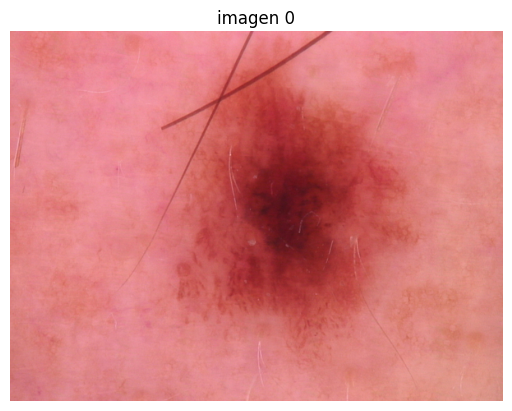

In [7]:
plt.imshow(images[0, :, :, :].astype('uint8'))  # Assuming pixel values are in [0, 255]
plt.title("imagen 0")
plt.axis('off')
plt.show()

In [8]:
masks.shape

(10015, 450, 600)

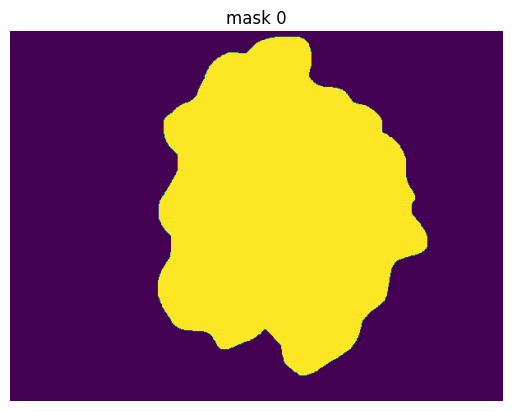

In [9]:
plt.imshow(masks[0, :, :].astype('uint8'))  # Assuming pixel values are in [0, 255]
plt.title("mask 0")
plt.axis('off')
plt.show()

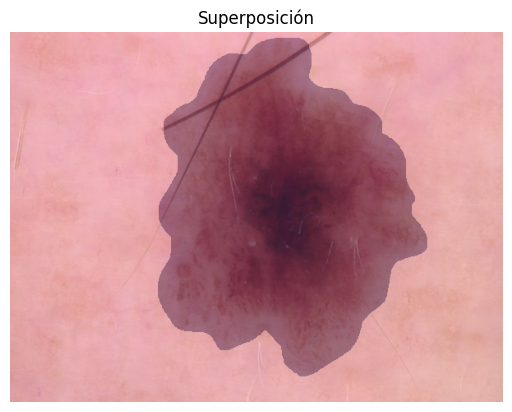

In [10]:
plt.imshow(images[0, :, :, :])
plt.imshow(masks[0, :, :], alpha=0.3, cmap='Blues')
plt.title('Superposición')
plt.axis('off')
plt.show()

In [11]:
labels.shape

(10015,)

In [12]:
labels[0]

'nv'

Los labels no tienen one hot encoding, pero no son nesesarios para una red de segmentacion 

## Normalización 

In [13]:
# Checkeo que el valor maximo es 255, de forma rapida
np.max(images[:,:,:,:])

255

In [14]:
np.max(masks[0,:,:])

255

In [15]:
# rescaling layer
rescale_layer = Rescaling(scale=1./255)

def preprocess_images(images, target_size=(100, 100)):
    #para compativilidad con tf
    images = images.astype(np.float32)
    # Resize 
    resized_images = resize(images, target_size)
    # Normalize images
    normalized_images = rescale_layer(resized_images)
    return normalized_images

Normalizacion imagenes 

In [16]:
# Process images in batches
batch_size = 100  # Adjust batch size based on your memory capacity
num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

preprocessed_images = []

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_images = images[start:end]
    
    # Preprocess the batch
    processed_batch = preprocess_images(batch_images)
    
    # Convert the processed batch to a NumPy array and store it
    preprocessed_images.append(processed_batch.numpy())
    
    # Delete the batch to free up memory
    del batch_images, processed_batch
     
    # Delete the processed batch from the original array to free up memory
    images[start:end] = np.zeros_like(images[start:end])  # Set to zeros to free up memory

# Concatenate all processed batches into a single array
preprocessed_images = np.concatenate(preprocessed_images, axis=0)

# Example: Display the shape of the preprocessed images
print(preprocessed_images.shape)

(10015, 100, 100, 3)


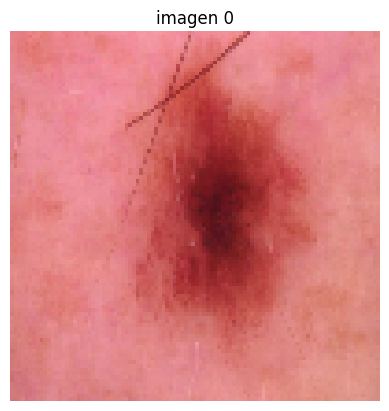

In [17]:
plt.imshow(preprocessed_images[0, :, :, :])
plt.title('imagen 0')
plt.axis('off')
plt.show()

verifico que se realizo correctamente la normalizacion 

In [18]:
print(f'el valor maximo para la normalizacion de imegenes es {np.max(preprocessed_images[:, :, :, :])}')
print(f'el valor minimo para la normalizacion de imagenes es {np.min(preprocessed_images[:, :, :, :])}')

el valor maximo para la normalizacion de imegenes es 1.0
el valor minimo para la normalizacion de imagenes es 0.0


Normalizacion masks 

In [19]:
# Function to preprocess masks
def preprocess_masks(masks, target_size=(100, 100)):
    # Convert masks to float32 for TensorFlow compatibility
    masks = masks.astype(np.float32)
    # Resize masks
    resized_masks = resize(masks[..., np.newaxis], target_size)
    # Normalize masks
    normalized_masks = rescale_layer(resized_masks)
    return normalized_masks

In [20]:
# Process masks in batches
batch_size = 100  # Adjust batch size based on your memory capacity
num_batches = len(masks) // batch_size + (1 if len(masks) % batch_size != 0 else 0)

preprocessed_masks = []

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_masks = masks[start:end]
    
    # Preprocess the batch
    processed_batch = preprocess_masks(batch_masks, target_size=(100, 100))
    
    # Convert the processed batch to a NumPy array and store it
    preprocessed_masks.append(processed_batch.numpy())
    
    # Delete the batch to free up memory
    del batch_masks, processed_batch
     
    # Delete the processed batch from the original array to free up memory
    masks[start:end] = np.zeros_like(masks[start:end])  # Set to zeros to free up memory

# Concatenate all processed batches into a single array
preprocessed_masks = np.concatenate(preprocessed_masks, axis=0)

# Example: Display the shape of the preprocessed masks
print(preprocessed_masks.shape)

(10015, 100, 100, 1)


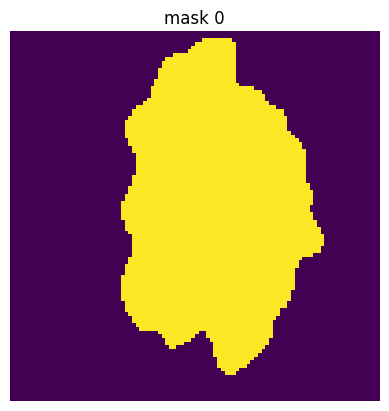

In [21]:
plt.imshow(preprocessed_masks[0, :, :].astype('uint8'))  # Assuming pixel values are in [0, 255]
plt.title("mask 0")
plt.axis('off')
plt.show()

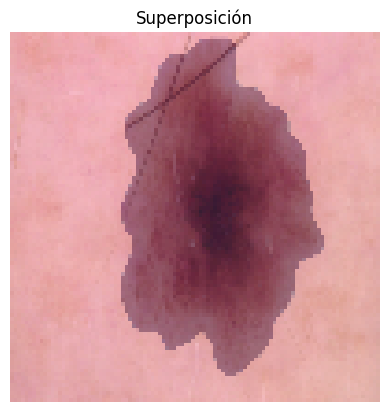

In [22]:
plt.imshow(preprocessed_images[0, :, :, :])
plt.imshow(preprocessed_masks[0, :, :], alpha=0.3, cmap='Blues')
plt.title('Superposición')
plt.axis('off')
plt.show()

In [23]:
print(f'el valor maximo para la normalizacion de imegenes es {np.max(preprocessed_masks[:, :, :, :])}')
print(f'el valor minimo para la normalizacion de imagenes es {np.min(preprocessed_masks[:, :, :, :])}')

el valor maximo para la normalizacion de imegenes es 1.0
el valor minimo para la normalizacion de imagenes es 0.0


## Train Test Split 

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, preprocessed_masks, test_size=0.1, random_state=42)

# Example: Display the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_val.shape)

X_train shape: (9013, 100, 100, 3)
X_test shape: (1002, 100, 100, 3)
y_train shape: (9013, 100, 100, 1)
y_test shape: (1002, 100, 100, 1)


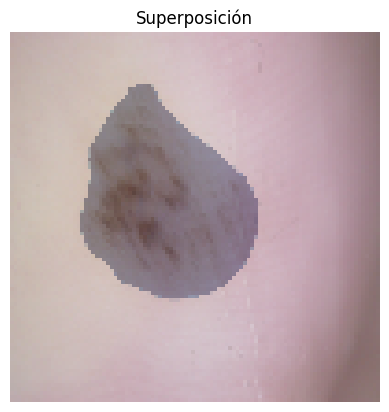

In [26]:
plt.imshow(X_train[0, :, :, :])
plt.imshow(y_train[0, :, :], alpha=0.3, cmap='Blues')
plt.title('Superposición')
plt.axis('off')
plt.show()

# 1) Diseñar una red tipo U-Net, teniendo en cuenta que se ajuste al tamaño y tipo de datos de las imágenes médicas. Entrenar el modelo para segmentar áreas específicas en las imágenes. Analizar los resultados y evaluar los errores.

Comparar las métricas de precisión, sensibilidad y especificidad Usar Grad-CAM para interpretar el modelo de clasificación y visualizar
qué áreas de las imágenes activaron más la red.

## Imports modelo

In [27]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow import GradientTape
from tensorflow import argmax
from tensorflow import reduce_mean
from tensorflow import reduce_sum
import tensorflow.keras.backend as K


In [28]:
from tensorflow.keras.layers import ZeroPadding2D

In [29]:
from tensorflow.keras.metrics import BinaryAccuracy

In [30]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow import convert_to_tensor


## Arquitectura modelo 

In [31]:
def encoder_block(inputs, num_filters): 
    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(inputs) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Max Pooling with 2x2 filter
    p = MaxPool2D(pool_size=(2, 2))(x) 
    return x, p

In [32]:
def decoder_block(inputs, skip_features, num_filters): 
    # Upsampling with 2x2 filter
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs) 

    # Ensure the shapes match by cropping or padding
    if x.shape[1] != skip_features.shape[1] or x.shape[2] != skip_features.shape[2]:
        x = ZeroPadding2D(((0, skip_features.shape[1] - x.shape[1]), (0, skip_features.shape[2] - x.shape[2])))(x)

    # Concatenate skip connections
    x = Concatenate()([x, skip_features]) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 
    return x

In [33]:
def unet_model(input_shape=(100, 100, 3), num_classes=1): 
    inputs = Input(input_shape) 
    
    # Contracting Path
    s1, p1 = encoder_block(inputs, 64) 
    s2, p2 = encoder_block(p1, 128) 
    s3, p3 = encoder_block(p2, 256) 
    s4, p4 = encoder_block(p3, 512) 
    
    # Bottleneck
    b1 = Conv2D(1024, 3, padding='same')(p4) 
    b1 = Activation('relu')(b1) 
    b1 = Conv2D(1024, 3, padding='same')(b1) 
    b1 = Activation('relu')(b1) 
    
    # Expansive Path
    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block(d1, s3, 256) 
    d3 = decoder_block(d2, s2, 128) 
    d4 = decoder_block(d3, s1, 64) 
    
    # Output Layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid' if num_classes == 1 else 'softmax')(d4) 
    
    model = Model(inputs, outputs, name='U-Net') 
    return model

## Grad-cam


In [34]:
def compute_gradcam(model, input_image, last_conv_layer_name):
    # Convert input image to a TensorFlow tensor
    input_image = convert_to_tensor(input_image, dtype='float32')

    # Create a model to access the final convolutional layer's output
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Calculate the gradients with respect to the output of the last convolutional layer
    with GradientTape() as tape:
        tape.watch(input_image)
        # Get the model's output and the last convolutional layer's output
        conv_output, predictions = grad_model(input_image)

        # Get the gradient of the predicted class with respect to the last conv layer output
        grads = tape.gradient(predictions, conv_output)

    # Calculate global average pooling of the gradients
    pooled_grads = reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the convolutional outputs by the pooled gradients
    conv_output = conv_output[0]
    heatmap = reduce_sum(pooled_grads * conv_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)  # Remove negative values
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    return heatmap, predictions

# Visualizing Grad-CAM
def display_gradcam(image, heatmap, mask, prediction, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to range [0, 255]
    heatmap = np.expand_dims(heatmap, axis=-1)  # Add a channel dimension
    heatmap = array_to_img(heatmap)  # Convert to image
    heatmap = heatmap.resize((image.shape[1], image.shape[0]))  # Resize heatmap to image size
    heatmap = np.array(heatmap)

    # Convert heatmap to RGB
    if len(heatmap.shape) == 2:
        heatmap = np.stack([heatmap] * 3, axis=-1)

    # Ensure the image is in the range [0, 255] and of type uint8
    image = (image * 255).astype('uint8')

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Plot the original image, heatmap, mask, and prediction
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')

    axes[3].imshow(prediction[0, :, :, 0], cmap='gray')
    axes[3].set_title('Prediction')
    axes[3].axis('off')

    plt.show()

## Metricas 

In [35]:
# Sensibilidad (Recall)
def sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    return true_positives / (possible_positives + K.epsilon())

# Especificidad
def specificity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)
    return true_negatives / (possible_negatives + K.epsilon())

# Precisión (Accuracy)
#def accuracy(y_true, y_pred):
    #return BinaryAccuracy()(y_true, y_pred)

## Call backs

In [36]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.75, 
                              patience=8, 
                              min_lr=1e-6, 
                              verbose=1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)

## Compile del modelo 

In [37]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)


model = unet_model(input_shape=(100, 100, 3), num_classes=1)
model.compile(optimizer= optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', sensitivity, specificity]
             )
model.summary()



Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 100,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 100,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 100,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 50,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 50, 50,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 50, 50,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 25,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 25, 25,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 25, 25,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 25, 25,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Remuevo la dmencion extra que se uso para la funcion de normalizacion 

In [38]:
y_train.shape

(9013, 100, 100, 1)

In [39]:
y_val.shape

(1002, 100, 100, 1)

In [40]:
y_train = np.squeeze(y_train, axis=-1)  # Remove the singleton dimension
y_val = np.squeeze(y_val, axis=-1)      # Remove the singleton dimension

In [41]:
y_val.shape

(1002, 100, 100)

In [42]:
y_train.shape

(9013, 100, 100)

## Entrenamiento 

In [43]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/5


I0000 00:00:1732840619.247705    1264 service.cc:145] XLA service 0x7b7d380028a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732840619.247779    1264 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732840619.247786    1264 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732840656.229978    1264 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 160s 417ms/step - accuracy: 0.8106 - loss: 0.4363 - sensitivity: 0.4606 - specificity: 0.8190 - val_accuracy: 0.8525 - val_loss: 0.3812 - val_sensitivity: 0.8261 - val_specificity: 0.7656 - learning_rate: 0.0010
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 284ms/step - accuracy: 0.9010 - loss: 0.2656 - sensitivity: 0.7214 - specificity: 0.8944 - val_accuracy: 0.9133 - val_loss: 0.2136 - val_sensitivity: 0.7540 - val_specificity: 0.9280 - learning_rate: 0.0010
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - accuracy: 0.9349 - loss: 0.1626 - sensitivity: 0.8245 - specificity: 0.9353 - val_accuracy: 0.9428 - val_loss: 0.1397 - val_sensitivity: 0.8910 - val_specificity: 0.9312 - learning_rate: 0.0010
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - accuracy: 0.9455 - loss: 0.1330 - sensitivity: 0.8568 - specificity: 0.9464 - val_accuracy: 0.9501 - val_loss: 0.1243 - val_sensitivity: 0.8687 - val_specificity: 0.9393 - learning_rate: 0.0010
Epoch 5/5

## Plot metrics

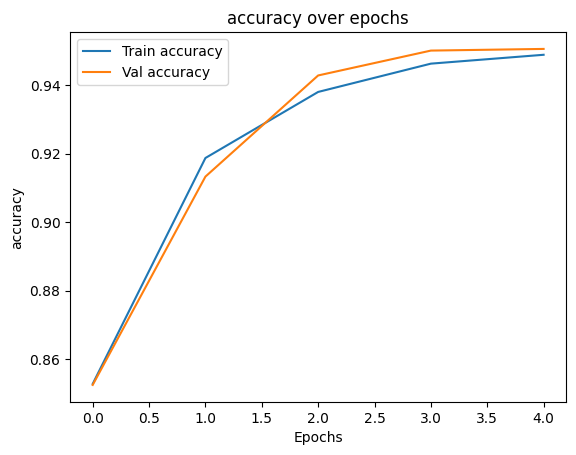

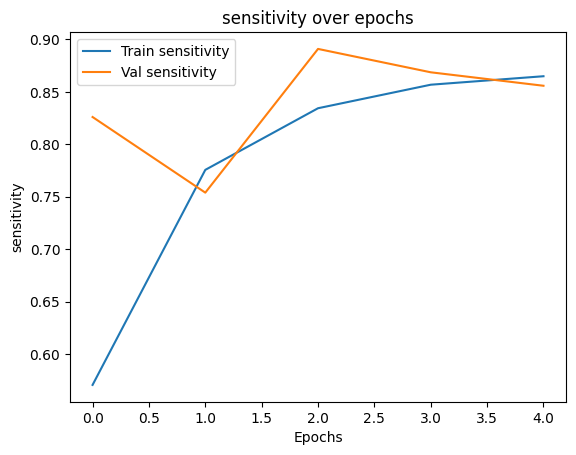

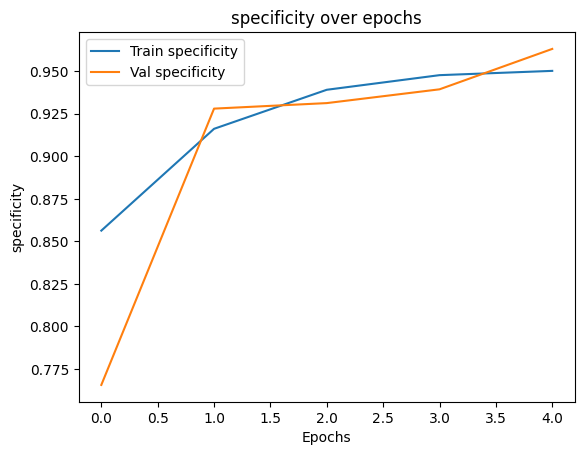

In [44]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric} over epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Graficar Accuracy, Sensitivity y Specificity
plot_metrics(history, 'accuracy')
plot_metrics(history, 'sensitivity')
plot_metrics(history, 'specificity')

## Visualizar resultados con Predicciones 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


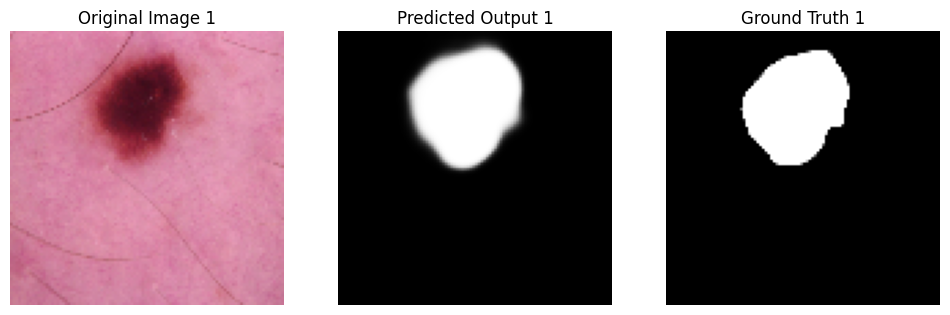

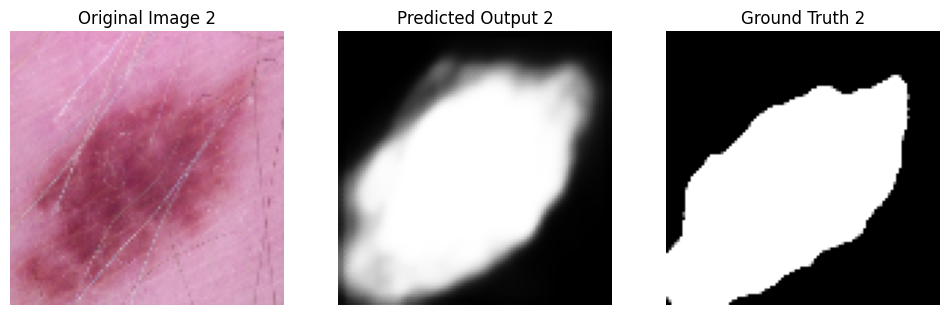

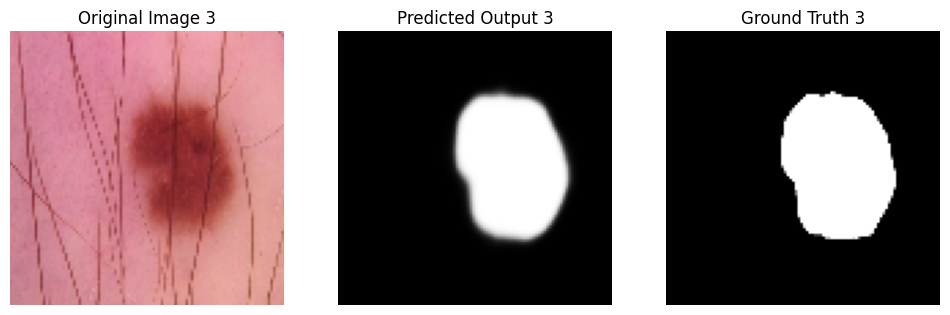

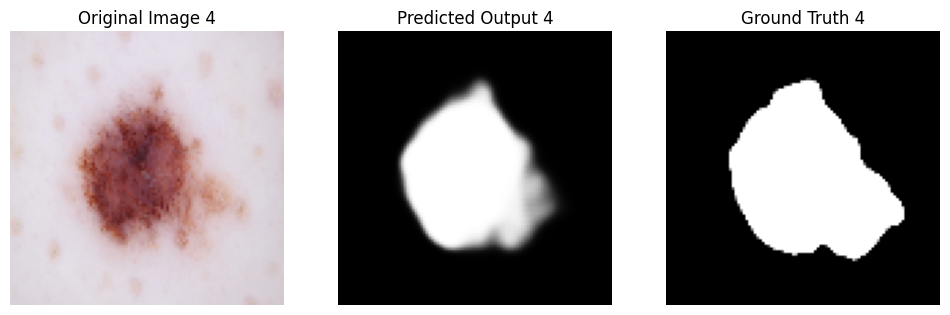

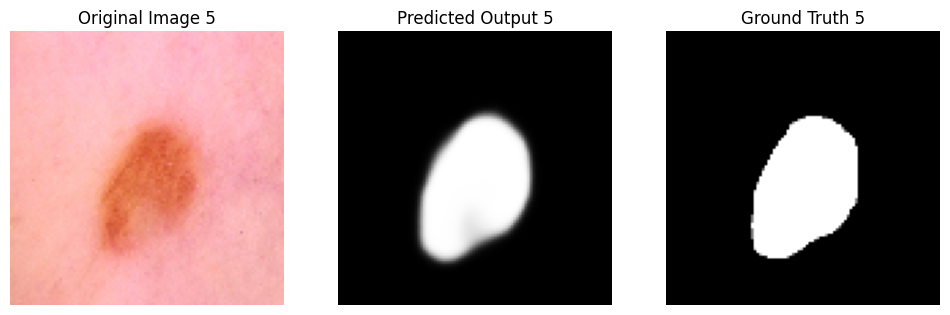

In [45]:
y_pred = model.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 4))

    # Original image (input image to the model)
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Predicted output (the model's output)
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred[i], cmap='gray')  # Use grayscale for segmentation maps
    plt.title(f"Predicted Output {i+1}")
    plt.axis('off')

    # Validation image (ground truth mask)
    plt.subplot(1, 3, 3)
    plt.imshow(y_val[i], cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Display the plot
    plt.show()

## Test Grad cam

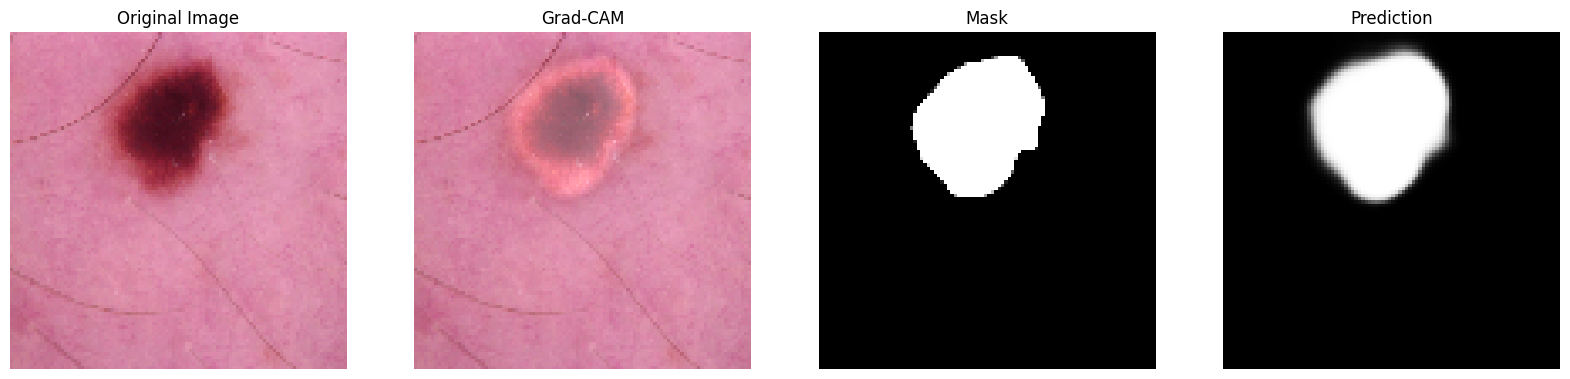

In [46]:
test_image = X_val[0:1]  # Select a test image
test_mask = y_val[0]  # Select the corresponding mask
heatmap, prediction = compute_gradcam(model, test_image, last_conv_layer_name='activation_17')
display_gradcam(test_image[0], heatmap, test_mask, prediction)



Se puede ver como los resultados son excelentes incluso a pocos epochs ya se logra una mejoría. En 5 epochs hubo una mejora constante de la val_accuracy  y las otras metricas tambien fueron muy altas 


En lo que consta a grad cam, se puede ver que claramente se focaliza en el tejido patológico, al ser justamente una salida binaria la imagen se ve que aprende que es tejido anormal y el resto lo toma como tejido sano.

## Guardo modelo 

In [47]:
# Save the entire model
model.save('my_model.h5')

# Optionally, save only the weights
model.save_weights('my_model_weights.weights.h5')

# 2) Descargar y cargar un modelo U-Net preentrenado para segmentación. Evaluar el modelo entrenado en la tarea de clasificación o segmentación, interpretar los resultados y hacer un análisis de errores. Comparara con el inciso anterior. rdida.

Comparar las métricas de precisión, sensibilidad y especificidad Usar Grad-CAM para interpretar el modelo de clasificación y visualizar
qué áreas de las imágenes activaron más la red.

## import u net 

In [48]:
from tensorflow.keras.models import load_model

In [49]:
# Load the entire model
model_loaded = load_model('/kaggle/working/my_model.h5')

## Continue trainning 

In [50]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_loaded = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)



Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 286ms/step - accuracy: 0.9538 - loss: 0.1105 - sensitivity: 0.8782 - specificity: 0.9557 - val_accuracy: 0.9510 - val_loss: 0.1167 - val_sensitivity: 0.8531 - val_specificity: 0.9621 - learning_rate: 0.0010
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 284ms/step - accuracy: 0.9545 - loss: 0.1085 - sensitivity: 0.8777 - specificity: 0.9574 - val_accuracy: 0.9554 - val_loss: 0.1078 - val_sensitivity: 0.8758 - val_specificity: 0.9573 - learning_rate: 0.0010
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 282ms/step - accuracy: 0.9575 - loss: 0.1000 - sensitivity: 0.8892 - specificity: 0.9599 - val_accuracy: 0.9560 - val_loss: 0.1097 - val_sensitivity: 0.8915 - val_specificity: 0.9633 - learning_rate: 0.0010
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - accuracy: 0.9605 - loss: 0.0923 - sensitivity: 0.8977 - specificity: 0.9626 - val_accuracy: 0.9564 - val_loss: 0.1033 - val_sensitivity: 0.8999 - val_specificity: 0.9544 - learning_rate: 0.0010


## Metricas

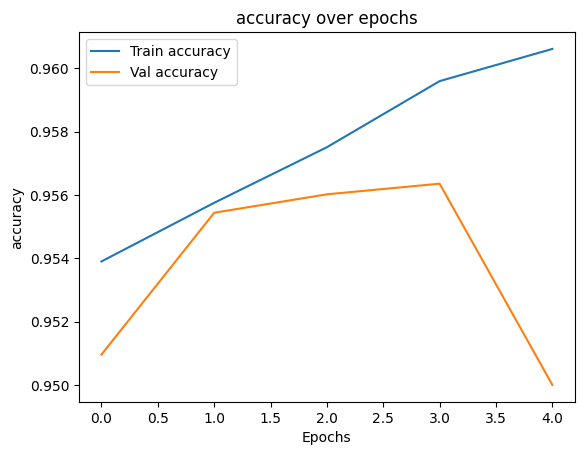

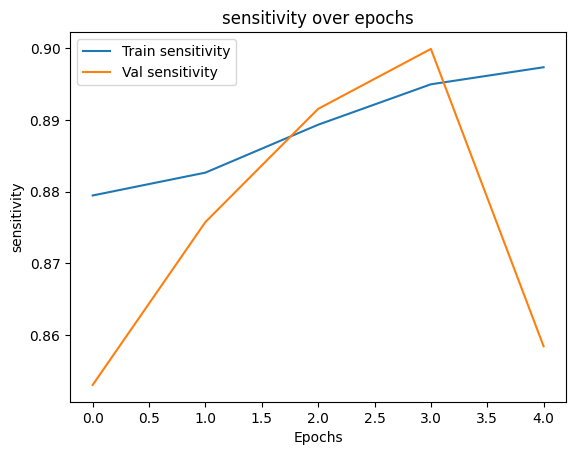

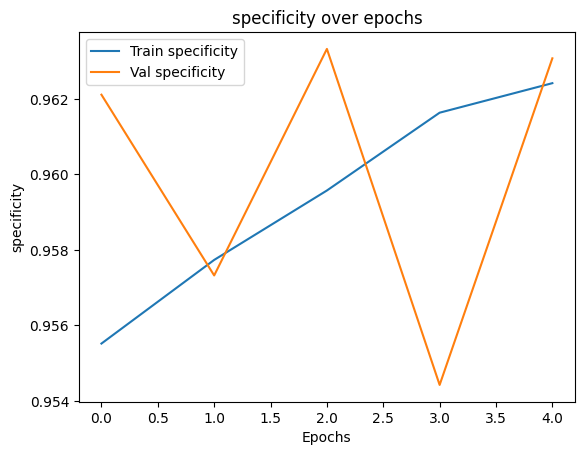

In [51]:
# Graficar Accuracy, Sensitivity y Specificity
plot_metrics(history_loaded, 'accuracy')
plot_metrics(history_loaded, 'sensitivity')
plot_metrics(history_loaded, 'specificity')

## Resultados con predicciones 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


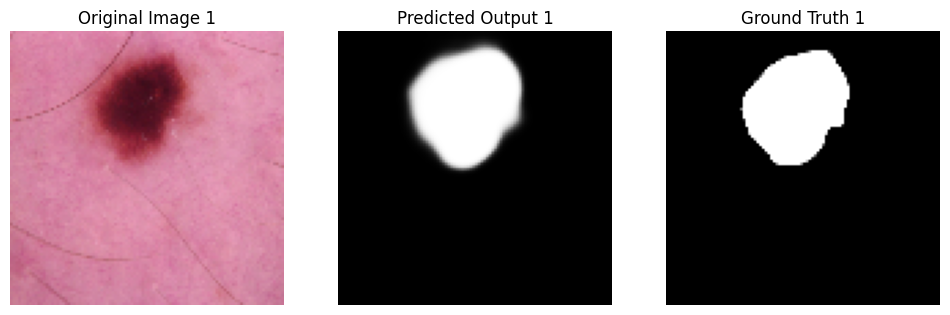

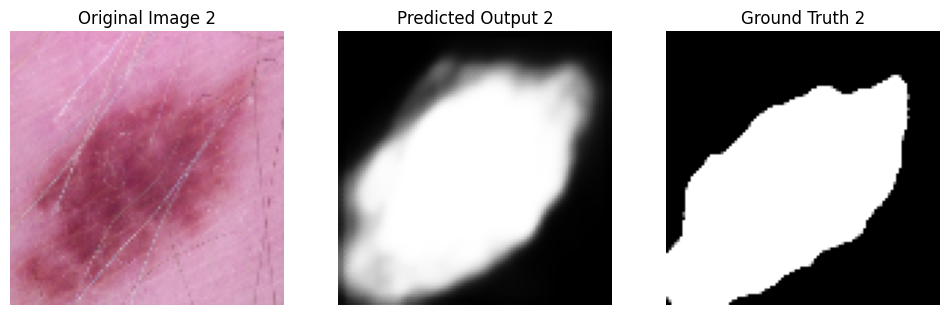

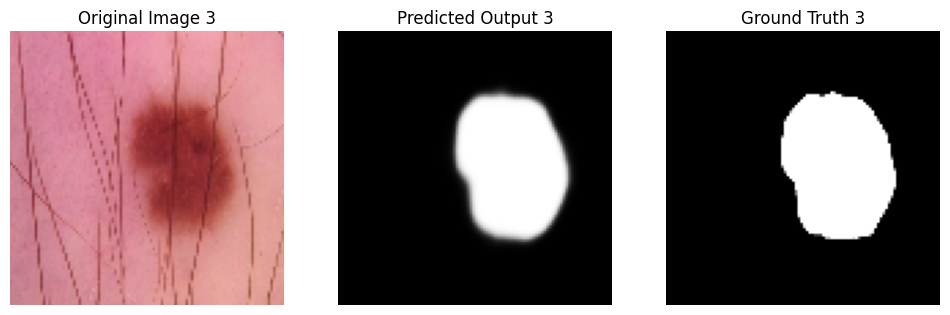

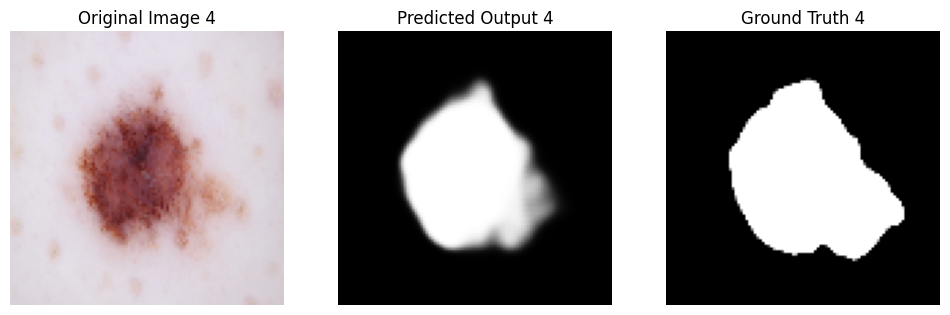

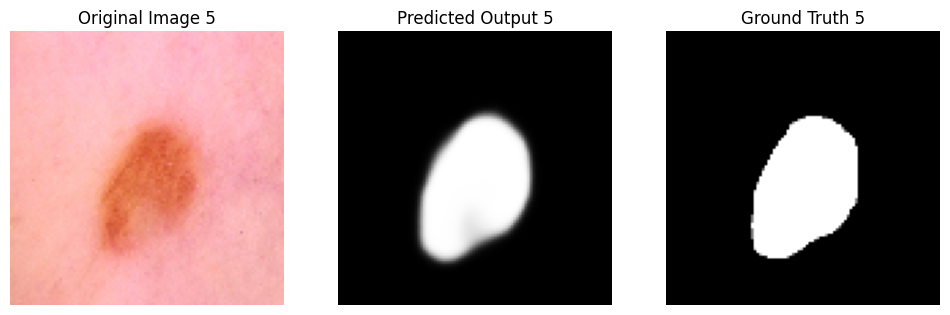

In [52]:
y_pred = model_loaded.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 4))

    # Original image (input image to the model)
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Predicted output (the model's output)
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred[i], cmap='gray')  # Use grayscale for segmentation maps
    plt.title(f"Predicted Output {i+1}")
    plt.axis('off')

    # Validation image (ground truth mask)
    plt.subplot(1, 3, 3)
    plt.imshow(y_val[i], cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Display the plot
    plt.show()

## Test Grad Cam

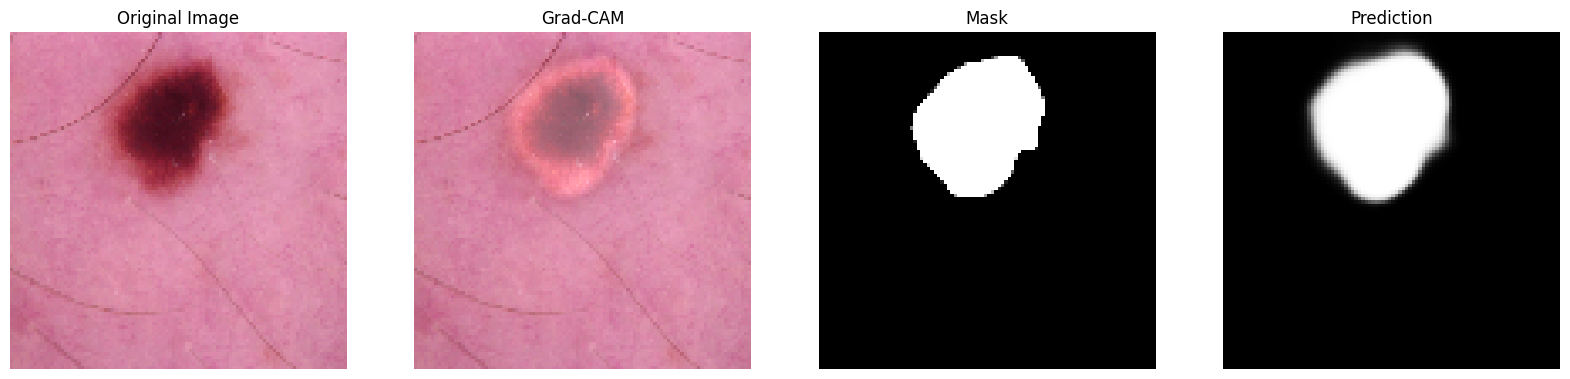

In [53]:
test_image = X_val[0:1]  # Select a test image
test_mask = y_val[0]  # Select the corresponding mask
heatmap, prediction = compute_gradcam(model_loaded, test_image, last_conv_layer_name='activation_17')
display_gradcam(test_image[0], heatmap, test_mask, prediction)



# 3) VII. Ajustar los hiperparámetros del modelo y comparen resultados antes y después de la optimización. Probar diferentes configuraciones en el modelo y analizar el impacto en la precisión y la pérdida.

Comparar las métricas de precisión, sensibilidad y especificidad Usar Grad-CAM para interpretar el modelo de clasificación y visualizar
qué áreas de las imágenes activaron más la red.

## Compilo el modelo nuevo

In [54]:
learning_rate = 0.01 ## Lr un orden de magnitud mas grande

optimizer = Adam(learning_rate=learning_rate)


model2 = unet_model(input_shape=(100, 100, 3), num_classes=1)
model2.compile(optimizer= optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', sensitivity, specificity]
             )
model2.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 100, 100,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 100, 100,  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 100, 100,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 100, 100,  │          0 │ conv2d_20[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 50, 50,    │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 50, 50,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 50, 50,    │          0 │ conv2d_21[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 50, 50,    │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 50, 50,    │          0 │ conv2d_22[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 25, 25,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 25, 25,    │          0 │ conv2d_23[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 25, 25,    │    590,080 │ activation_22[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 25, 25,    │          0 │ conv2d_24[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 12, 12,    │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 12, 12,    │  1,180,160 │ max_pooling2d_6[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento 

In [55]:
# Define ReduceLROnPlateau callback
# hago que el reduced learning rate on plateau sea mas estricto es decir disminuya mas rapido
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, #reduzco el factor 
                              patience=5, #reduzco la paciencia 
                              min_lr=1e-6, 
                              verbose=1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7313 - loss: 4.1430 - sensitivity: 0.0193 - specificity: 0.9808 - val_accuracy: 0.7226 - val_loss: 4.4358 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - learning_rate: 0.0100
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 496ms/step - accuracy: 0.7347 - loss: 4.2412 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_accuracy: 0.7226 - val_loss: 4.4358 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - learning_rate: 0.0100
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 495ms/step - accuracy: 0.7317 - loss: 4.2892 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_accuracy: 0.7226 - val_loss: 4.4358 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - learning_rate: 0.0100
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 494ms/step - accuracy: 0.7308 - loss: 4.3035 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_accuracy: 0.7226 - val_loss: 4.4358 - val_sensitivity: 0.0000e+00 - val_specificity: 1.000

## Metricas

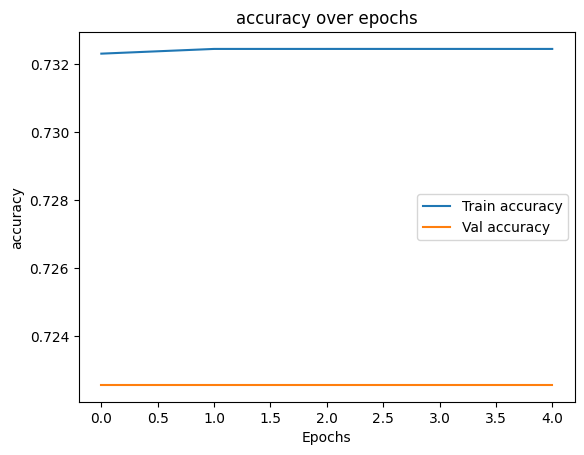

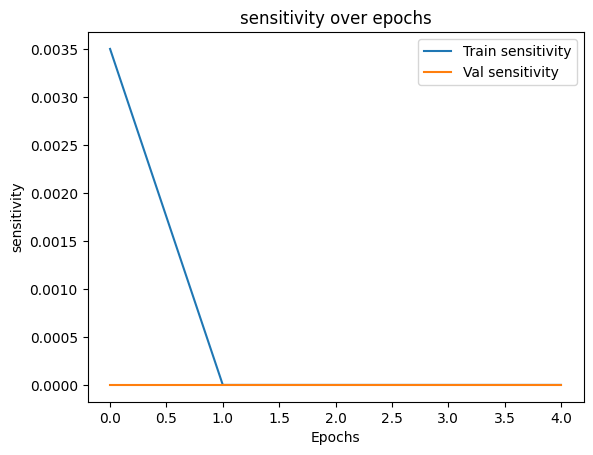

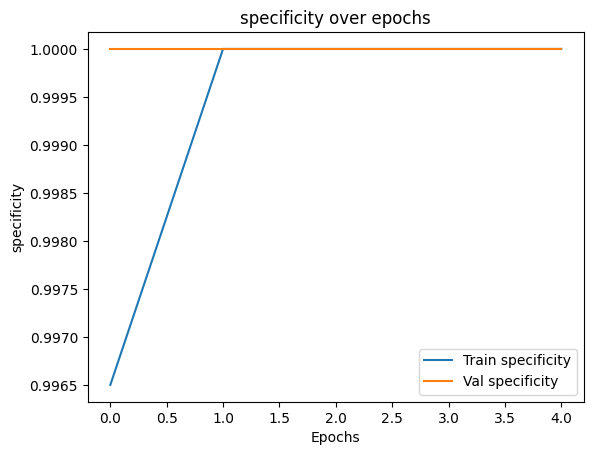

In [56]:
# Graficar Accuracy, Sensitivity y Specificity
plot_metrics(history2, 'accuracy')
plot_metrics(history2, 'sensitivity')
plot_metrics(history2, 'specificity')


## Predicciones 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


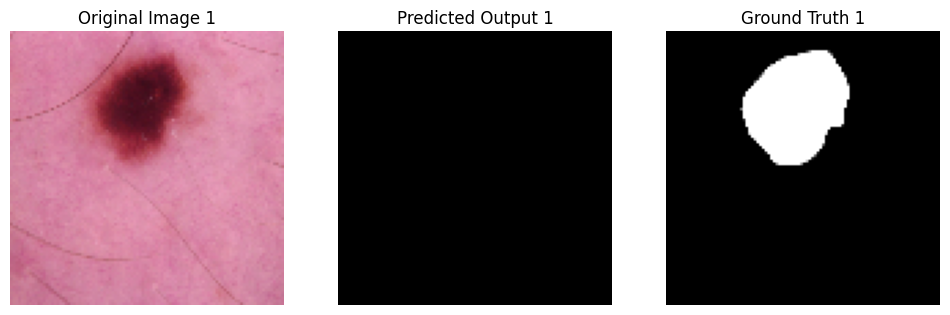

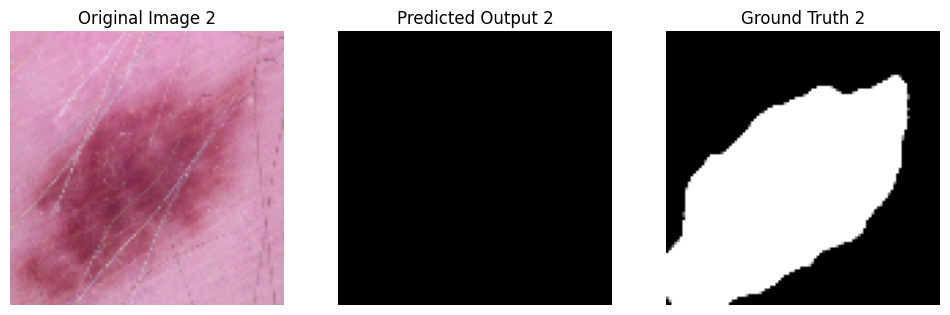

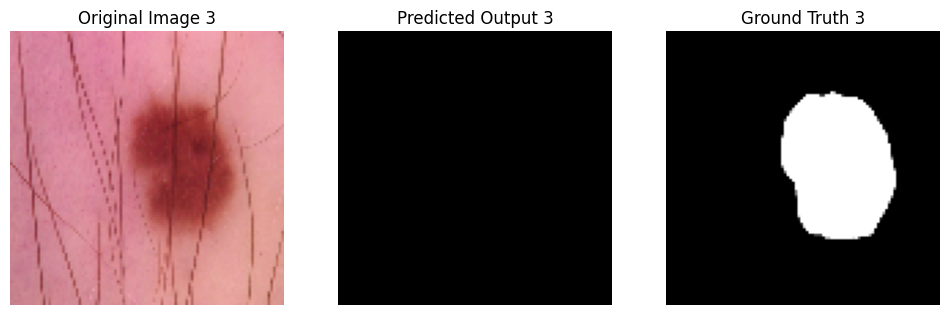

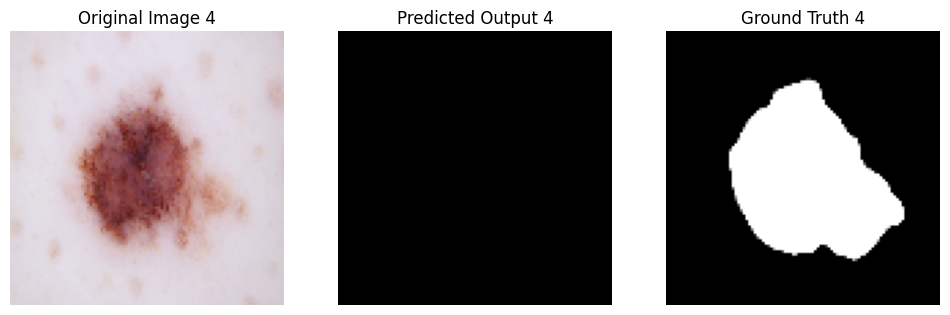

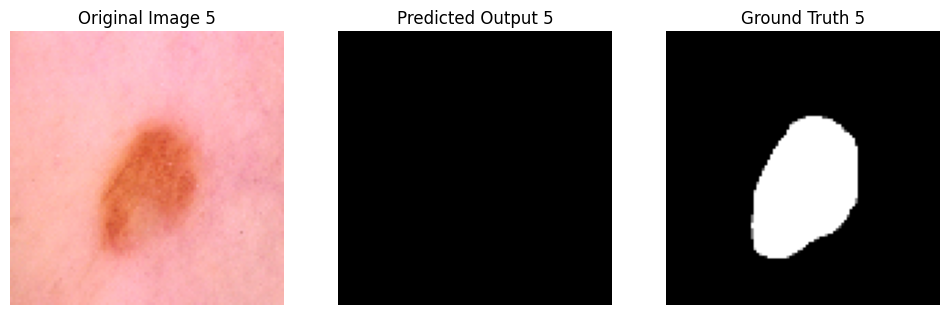

In [57]:
y_pred = model2.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 4))

    # Original image (input image to the model)
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Predicted output (the model's output)
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred[i], cmap='gray')  # Use grayscale for segmentation maps
    plt.title(f"Predicted Output {i+1}")
    plt.axis('off')

    # Validation image (ground truth mask)
    plt.subplot(1, 3, 3)
    plt.imshow(y_val[i], cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Display the plot
    plt.show()

## Test grad cam 

/tmp/ipykernel_1219/176350108.py:29: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize to [0, 1]
/tmp/ipykernel_1219/176350108.py:34: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)  # Scale heatmap to range [0, 255]


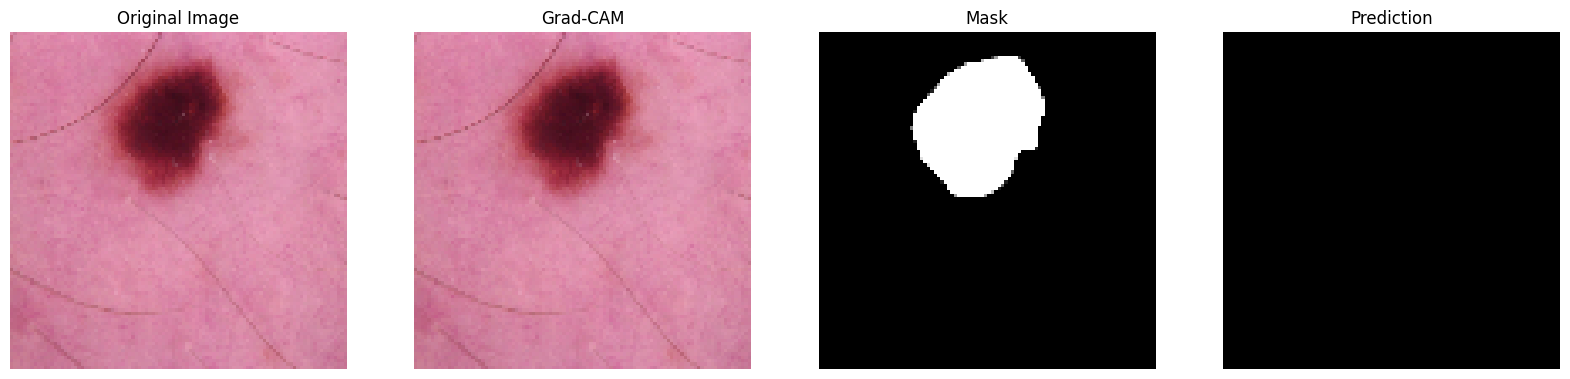

In [60]:
test_image = X_val[0:1]  # Select a test image
test_mask = y_val[0]  # Select the corresponding mask
heatmap, prediction = compute_gradcam(model2, test_image, last_conv_layer_name='activation_35')
display_gradcam(test_image[0], heatmap, test_mask, prediction)


# Comparar los resultados obtenidos en cada inciso ¿Que conclusiones puede sacar?, ¿Cuál es el tipo de U-NET que funciona mejor?¿Como haría para evaluar si la calidad de la imagen afecta la segmentación?n?

La red creada en el primer punto cuenta de base con resultados exelentes incluso con pocos epochs.
Como es de esperar la red continua aprendiendo y mejorando al hacer un par de epochs más en lo que consta a la accuracy, sin embargo para las otras metricas hay un desenso considerable en alhunos entrenamientos y en otrso se mantienen con los buenos resultados que se tenian en un principio.

A manera de comentario, se realizan pocos epochs ya que el data set tarda en correr y aprende bastante rapido, por ello los callbacks no surten tanto efecto 

Es complicado mejorar los hiperparametros ya que la red base tenia muy buenos resultrados, asi que se intento ver si se aumentaba el Learning rate y el batch, para ver si con un entrenamiento que deberia tardar menos tiempo tiene los mismos resultados. Parace ser que los cambios no fueron beneficiosos 


La calidad de la imagen parece que no afecta mucho, ya que se cambio la resolucion de 450,600 a 100,100 y los resultados fueron muy buenos. En problema para probar resultados a altas resoluciones es que estamos limitados con el espacio de RAM ya caragar el data set a el tamaño comprimido ocuopa 20 GB de Ram, incluso haciendolo de forma iteligente borrando la informacion del array orinal a medida que se hacia la normalizacion y reescalamiento.Pero si se contara con mayores recursos entreanaria diferentes redes con diferentes tamaños de imagenes de entrada para ver esto mismo.